# Machine Learning Project: Logistic Regression

For this project, we will reuse much of the functions and logic of our previous work on linear regression (https://github.com/iv-stpn/linear-regression-examples).

Like last time, first of all, we create a cell for all the libraries we will need to import for our project. We will use pandas to import and manipulate data easily through DataFrames, NumPy for linear algebra & complex operations over lists, Matplotlib for displaying 2D plots, Seaborn for displaying correlation heatmaps, scikit-learn for model engineering & some extra utilities.

<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [99]:
import time
from math import sqrt

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, f1_score, precision_score, recall_score

import tensorflow as tf
import warnings

We set some parameters to increase the height of Matplotlib figures, pandas print outputs so they can be displayed properly in the notebook and to assure that DeprecationWarnings will not be displayed.

In [100]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 1000)

warnings.filterwarnings("ignore", category=DeprecationWarning) 

We create a function to display and analyse the results of our regressions feature-by-feature (with scatter plots & lines corresponding to the coefficients of each weight).

In [4]:
def plot_weights_data_biasless(plt, X, y, w, title, same_scale = True):
    intercept = w[0]
    w = w[1:]
    
    n = len(w)
    fig, axs = plt.subplots(2, n)
    fig.suptitle(title, fontsize=20)
    y_scale_line = (-1*((max(y)-min(y))/2), (max(y)-min(y))/2)
    y_scale = (min(y), max(y))
    
    x_minimums = X.T.min(axis = 1)
    x_maximums = X.T.max(axis = 1)
    x_size = x_maximums - x_minimums
    max_size = max(x_size)
    
    x = np.linspace(-100, 100, 100)
    for i in range(n):
        if same_scale:
            diff_size = max_size - x_size[i]
            x_scale = (x_minimums[i] - diff_size/2, x_maximums[i] + diff_size/2)            # We make it so all x scales are on the same scale
            
            if (n > 1):
                axs[0][i].set_xlim(x_scale)
                axs[0][i].set_ylim(y_scale)
            else:
                axs[0].set_xlim(x_scale)
                axs[0].set_ylim(y_scale)

            #axs[0][i].scatter(X[:, i], y, c=) 
            heatmap, xedges, yedges = np.histogram2d(np.concatenate((X[:, i], x_scale)),    # We add a point in the upper-left corner and upper-right corner of the heatmap
                                                     np.concatenate((y, y_scale)), bins=50) # so all heatmaps will have the same edges and be displayed correctly
        else:
            heatmap, xedges, yedges = np.histogram2d(X[:, i], y, bins=50)
        
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
        if (n > 1):
            axs[1][i].set_xlim((-2, 2))
            axs[1][i].set_ylim(y_scale_line)
            axs[1][i].plot(x, w[i]*x, c="red", linewidth=2)
        else:
            axs[1].set_xlim((-2, 2))
            axs[1].set_ylim(y_scale_line)
            axs[1].plot(x, w[i]*x, c="red", linewidth=2)
        
    fig.tight_layout()

# First Dataset: Analysis & Model Fitting of the Loan Approval Dataset

The dataset can found in the project folder (loan_prediction.csv), and was originally used in an Analytics Vidhya practice problem (https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/). It contains 12 variables and one output and only 615 rows.

In [5]:
def load_data_csv(csv_path, drops=[]):
    df = pd.read_csv(csv_path)  

    for drop in drops:                               # We add an optional "drops" argument, telling which columns to drop as soon as the data is loaded
        df = df.drop(drop, axis=1)
    
    return df

In [6]:
def put_nan_in_front(array):
    idx = -1
    if (array.dtype == "object"):
        is_string = [type(value) == str for value in array]
        if any(is_string):
            idx = is_string.index(False) if False in is_string else -1
        else:
            idx = -1
    else:
        for dtype in ("int64", "float64"):
            if array.dtype == dtype:
                idx = np.argwhere(np.isnan(np.array(array, dtype=dtype)))
                if idx.size == 0:
                    idx = -1
                break

    array = [str(i) for i in array]
    
    if idx > 0:
        array[int(idx)], array[0] = array[0], "N/A"
    elif idx == 0:
        array[0] = "N/A"
    
    return array

def string_shortener(string, limit):
    if len(string) > limit:
        string = string[:limit-4] + " ..."
    return string

join = lambda array, delim: delim.join([str(i) for i in array])
join_shorten = lambda array, delim, limit: string_shortener(join(array, delim), limit)
join_shorten_ = lambda array: join_shorten(array, " - ", 40)

def unique_df(df):
    number_unique = []
    unique = []
    unique_count_values = []
    unique_count_proportions = []

    for column in df.columns:
        unique_column = df[column].unique()
        unique_count = df.groupby(column)["Loan_ID"].nunique()

        n_unique_without_nan = len(unique_count.index)
        unique_count = unique_count.values

        if (len(unique_column) > n_unique_without_nan):
            unique_count = np.concatenate([[len(df) - sum(unique_count)], unique_count])
        
        unique_column = put_nan_in_front(unique_column)
        number_unique.append(len(unique_column))
        unique.append(join_shorten_(unique_column))
        unique_count_values.append(join_shorten_(unique_count))
        unique_count_proportions.append(join_shorten_(map(lambda x: str(x) + "%", np.round(unique_count/sum(unique_count), 2))))


    df_unique = pd.DataFrame(zip(df.columns, number_unique, [str(dtype) for dtype in df.dtypes], unique, unique_count_values, unique_count_proportions),
                            columns = ["Column names", "# Unique Values", "Data Type", "Unique values", "Unique value counts", "Unique value proportions"])

    df.set_index("Loan_ID", inplace=True)
    print(df.columns)
    print()
    print("Sample of 10 individuals from the dataset:")
    print()
    print(df.sample(10))
    print()
    print("Unique values:")
    print()
    print(df_unique)

    return df_unique, df

In [7]:
df = load_data_csv("loan_prediction.csv")
df_unique, df = unique_df(df)

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'], dtype='object')

Sample of 10 individuals from the dataset:

          Gender Married Dependents     Education Self_Employed  ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History Property_Area Loan_Status
Loan_ID                                                                                                                                                                    
LP002585    Male     Yes          0      Graduate            No             3597             2157.0       119.0             360.0             0.0         Rural           N
LP002739    Male     Yes          0  Not Graduate            No             2917              536.0        66.0             360.0             1.0         Rural           N
LP002757  Female     Yes          0  Not Graduate     

The "Loan ID" column, using unique identifiers for each row (individual) will serve as our index. The "Loan Status" column, indicating whether a given loan application was accepted or denied, will serve as our output feature; since it is a binary variable, we know that our prediction problem can be solved using a Binary Logistic Regression. We will showcase different types of Logistic Regression models to achieve the best prediction scores.

As we can notice, there are some data points missing; mainly, we are missing 4% of the Loan Amounts, 5% of the employment information (self-employed or not), and 8% of the credit histories. To start our first analysis of the variables (by studying intercorrelations for example), we will need to fill those missing data points with approximative data, estimating what the true data could have been. However, paradoxically, we need to know more about our data to be able to fill those data points meaningfully, because if we just fill them using the averages or the modes of the columns, we might end up with a biased model based on incorrect assumptions that our missing data points were similar the means of the columns. As a compromise, we will consider missing data in our categorical variables as a special category ("Unspecified data") before one-hot encoding them, and remove rows with missing data in the case of the critical numerical column (i.e. the Loan Amount & the Loan Amount Term), and then add the rows back with an adapted prediction of what the value could have realistically been based on the other information we still have about the row.

In [8]:
def one_hot_encoded_filled_dataset():
    df = load_data_csv("loan_prediction.csv")
    df.set_index("Loan_ID", inplace=True)
    df["Gender"] = df["Gender"].fillna("Unspecified")
    df["Married"] = df["Married"].fillna("Unspecified")
    df["Dependents"] = df["Dependents"].fillna("Unspecified")
    df["Self_Employed"] = df["Self_Employed"].fillna("Unspecified")
    df["Credit_History"] = df["Credit_History"].fillna(2.0)
    df = df.replace({"Loan_Status": {"N": "0", "Y": "1"}})
    df["Loan_Status"] = pd.to_numeric(df["Loan_Status"])

    df = pd.get_dummies(data=df, columns=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Credit_History", "Property_Area"])
    col_list = list(df)
    idx = col_list.index("Loan_Status")
    col_list[idx], col_list[-1] = col_list[-1], col_list[idx]

    return df

def drop_na_loan_amounts_model():
    df = one_hot_encoded_filled_dataset()
    df = df.dropna()
    return df

ApplicantIncome                int64
CoapplicantIncome            float64
LoanAmount                   float64
Loan_Amount_Term             float64
Loan_Status                    int64
Gender_Female                  uint8
Gender_Male                    uint8
Gender_Unspecified             uint8
Married_No                     uint8
Married_Unspecified            uint8
Married_Yes                    uint8
Dependents_0                   uint8
Dependents_1                   uint8
Dependents_2                   uint8
Dependents_3+                  uint8
Dependents_Unspecified         uint8
Education_Graduate             uint8
Education_Not Graduate         uint8
Self_Employed_No               uint8
Self_Employed_Unspecified      uint8
Self_Employed_Yes              uint8
Credit_History_0.0             uint8
Credit_History_1.0             uint8
Credit_History_2.0             uint8
Property_Area_Rural            uint8
Property_Area_Semiurban        uint8
Property_Area_Urban            uint8
d

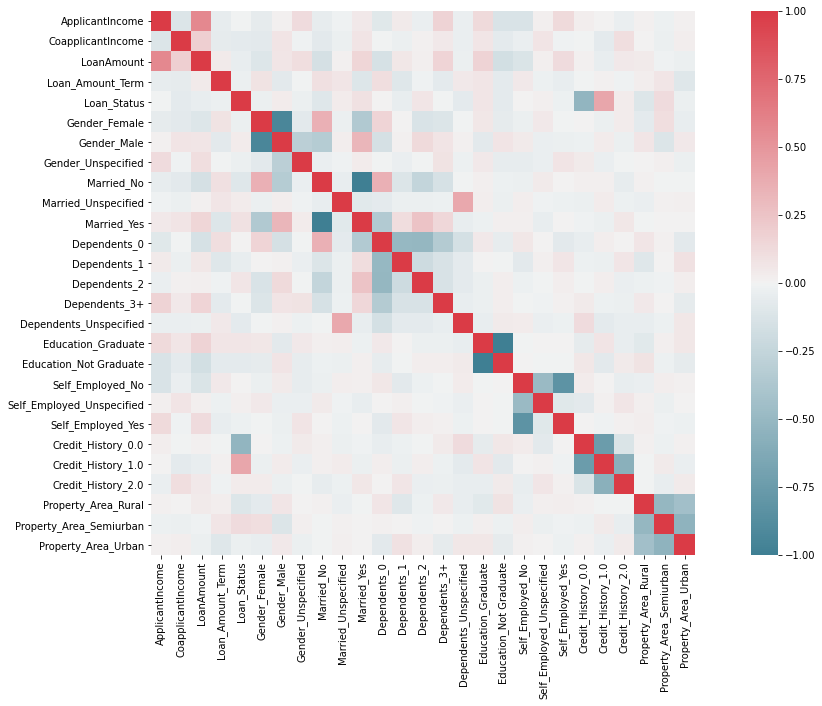

In [11]:
df = drop_na_loan_amounts_model()

print(df.dtypes)
print(df)

corr = df.corr()

print(corr)

fig, ax = plt.subplots(1, 1, figsize=(20,10))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

print("");

We can see that the Loan Amount is mostly correlated with the Applicant & Coapplicant Income, whether the individual is self-employed/a graduate or not and whether the individual has more than 3 financial dependants.

We will train models on the data with and without the rows where the Loan Amount is missing (recreating the values based on the observed correlations).


## Part I: Logistic Regression from Scratch

To normalize the features, we implement a function with two modes, "min-max" or "z-score" to use either of those methods for feature scaling. The function also add a 1s column for the bias (intercept) of the linear regression.

In [13]:
def normalizeFeatures(X, mode="min-max"):   # Put all columns (classes) on the same scale (scaling) and brings them on the origin [0; 1]
                                            # And add a 1s column for the factor associated to the bias 

    X_t = X.T # Go from the individual points as lines to columns as lines (by default numpy operations are applied line by line)
              #
              # x11, x12, x13, x14    x11, x21, x31
              # x21, x22, x23, x24 -> x12, x22, x32
              # x31, x32, x33, x34    x13, x23, x33
              #                       x14, x24, x34

    # For normalization we suppose no variable has always the same value (otherwise there would a division by 0)
    # If a variable has always the same value, it should be removed from the dataset as it is pointless in the linear regression
    
    
    if (mode == "min-max"): # Feature scaling using minimums and maximums
        minimums = X_t.min(axis = 1)[:, None] # Create a new axis to convert scalars to 1-element arrays
        maximums = X_t.max(axis = 1)[:, None] # Create a new axis to convert scalars to 1-element arrays
        X_t = (X_t - minimums) / (maximums - minimums)

    elif (mode == "z-score"): # Feature scaling using z_scores
        X_t = (X_t - X_t.mean(axis = 1)[:, None]) / X_t.std(axis = 1)[:, None]

    X = X_t.T
    X = np.c_[np.ones((X.shape[0], 1)), X] # Add a 1s column to the new scaled matrix for the bias for matrix multiplications
    
    return X

We then implement our hypothesis function ; unlike in a linear regression, the hypothesis function of a logistic regression isn't as trivial as a matrix multiplication between the features and the weights: it will require to apply the sigmoid function to the result of our matrix multiplication (to force our hypothesis between 0 and 1).

For the reminder of this notebook, we will use the 'at' operator (@) for matrix multiplication (https://www.python.org/dev/peps/pep-0465/)

In [14]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def hypothesis(X,w):
    return sigmoid(X @ w)

We will implement a Cross-Entropy Cost Function (as we are in the case of a binary output variable), that is the sum of how exponentially far the hypothesis is from a correct guess if the individual corresponds to the state y=1 ( $-y*(\log(h(X,w)))$ ) and if it corresponds to the state y=0 ( $-(1-y)*(1-\log(h(X,w)))$ ). The functions $\log(x)$ and $1-\log(x)$ are convex (for $x \in ]0; 1[$), so their sum is convex. Since the two functions are symmetrical, the sum of the two will share a common global minimum.

The final formula of the Cross-Entropy Cost Function is $-(y*(\log(h(X, w))) + (1-y)*(\log(1-h(X,w))))$. Plotted below, we can see that such a cost function punishes wrong predictions much more than it rewards correct predictions.


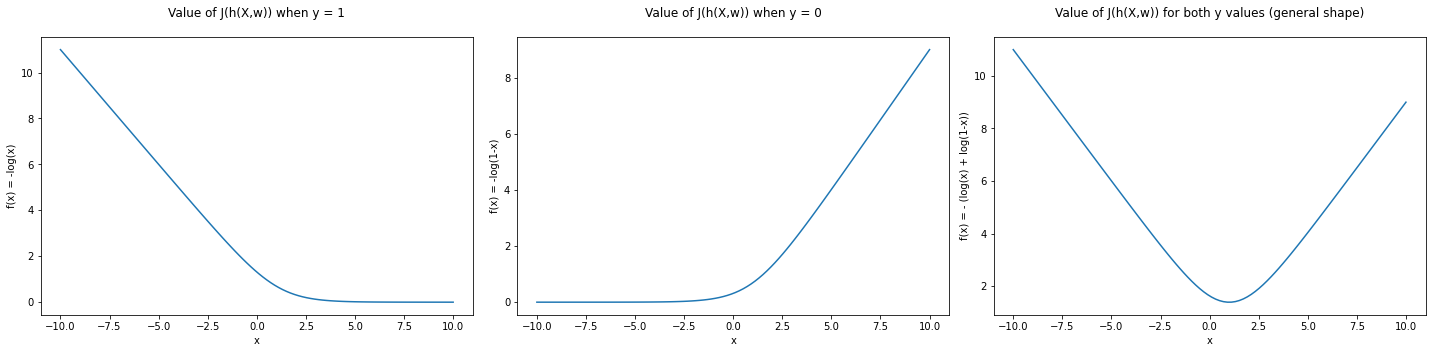

In [22]:
fig, axs = plt.subplots(1, 3)
x = np.linspace(-10, 10, 100)

weight = 1
bias = -1
f = weight*x + bias
h = sigmoid(f)
h = h[(h != 0) & (h != 1)]

x = np.linspace(-10, 10, len(h))

axs[0].plot(x, -np.log(h))
axs[0].set_title("Value of J(h(X,w)) when y = 1", y=1.05)
axs[0].set_xlabel('x', fontsize=10)
axs[0].set_ylabel('f(x) = -log(x)', fontsize=10)

axs[1].plot(x, -(np.log(1-h)))
axs[1].set_title("Value of J(h(X,w)) when y = 0", y=1.05)
axs[1].set_xlabel('x', fontsize=10)
axs[1].set_ylabel('f(x) = -log(1-x)', fontsize=10)

axs[2].plot(x, -(np.log(h)+(np.log(1-h))))
axs[2].set_title("Value of J(h(X,w)) for both y values (general shape)", y=1.05)
axs[2].set_xlabel('x', fontsize=10)
axs[2].set_ylabel('f(x) = - (log(x) + log(1-x))', fontsize=10)

x_sigmoid = np.linspace(0.01, 0.99, 100)

fig.tight_layout()

print()

We will also experiment with the Squared Loss Cost Function, where the cost function is the sum of the squares of how far the hypothesis is from the correct answer in the case where y = 0 ( $y*(h(X,w)^2)$ ) and y = 1 ( $(1-y)*(1-h(X,w))^2$ ).

The final formula of our Squared Loss Cost Function is: $y*(h(X,w)^2)+(1-y)*(1-h(X,w))^2$.

Traditionnally, this cost function is not used in logistic regression because it is neither convex nor concave (https://math.stackexchange.com/questions/1985008/show-that-logistic-regression-with-squared-loss-function-is-non-convex, https://www.internalpointers.com/post/cost-function-logistic-regression).

However, such a cost function can still be used for logistic regression as it has a global minimum, and following its gradient descent will always lead to its global minimum; if we are too far from the minimum, the function will struggle to go back towards it, which is why we need to use a very small $\Delta$, and a very large $\alpha$.

As we will see, the Squared Loss Cost Function for logistic regression is much more computationnally effective than the Log Loss for each successive cost is much less computationally-friendly than calculating polynomials in the cost function & the gradient (see calculation of the Squared Loss Cost Function below).

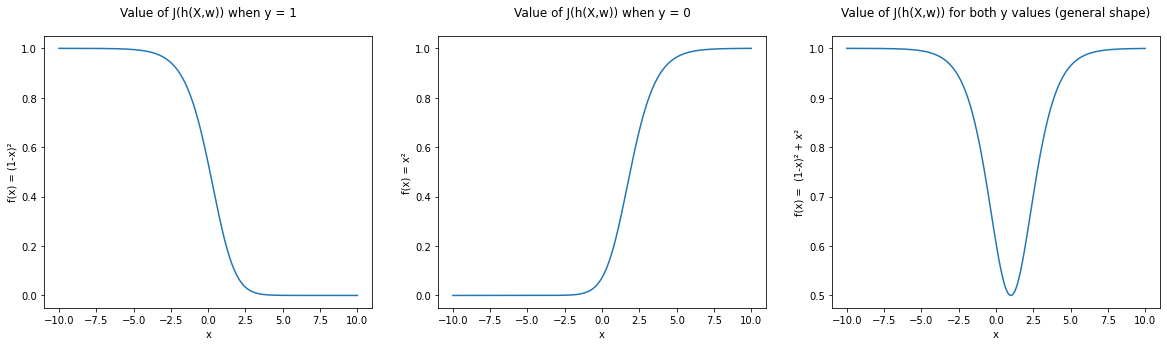

In [29]:
fig, ax = plt.subplots(1, 3)
x = np.linspace(-10, 10, 1000)

weight = 1
bias = -1
f = weight*x + bias
h = sigmoid(f)
h = h[(h != 0) & (h != 1)]

x = np.linspace(-10, 10, len(h))

ax[0].plot(x, (1-h)**2)
ax[0].set_title("Value of J(h(X,w)) when y = 1", y=1.05)
ax[0].set_xlabel('x', fontsize=10)
ax[0].set_ylabel('f(x) = (1-x)²', fontsize=10)

ax[1].plot(x, h**2)
ax[1].set_title("Value of J(h(X,w)) when y = 0", y=1.05)
ax[1].set_xlabel('x', fontsize=10)
ax[1].set_ylabel('f(x) = x²', fontsize=10)

ax[2].plot(x, (1-h)**2+h**2)
ax[2].set_title("Value of J(h(X,w)) for both y values (general shape)", y=1.05)
ax[2].set_xlabel('x', fontsize=10)
ax[2].set_ylabel('f(x) =  (1-x)² + x²', fontsize=10)

print()


$ 
\begin{align}
\dfrac{\delta}{\delta w} J \big( h(X, w) \big) &= \dfrac{\delta}{\delta w} \Big( y\big(1-h(X, w)\big)² + (1-y)h(X, w)² \Big) \\
&= \dfrac{\delta}{\delta w} \big( y + yh(X, w)² - 2yh(X, w) + h(X, w)² - yh(X, w)² \big) \\[0.1cm]
&= \dfrac{\delta}{\delta w} \big( h(X, w)² - 2yh(X, w) + y \big) \\[0.1cm]
&= \ 2h'(X, w) h(X,w) - 2h'(X, w)y \\[0.2cm]
&= \ 2σ'(Xw) σ(Xw) - 2σ'(Xw)y\\[0.1cm]
&= \bigg( 2X^T\Big( \big[ \big(1-σ(Xw)\big)σ(Xw) \big]σ(Xw) \Big) - 2X^T\Big( \big[ σ(Xw)\big(1-σ(Xw)\big) \big]y \Big) \bigg) \ \ \ \ \ \ \Big( \text{because } \dfrac{d}{dw} ( σ(Xw) ) = X^Tσ(Xw)(1-σ(Xw)) \Big) \\
&= 2X^T \Big( -σ³(Xw) + σ²(Xw) - y\big( -σ(Xw)² + σ\left(Xw\right) \big) \Big) \\[0.1cm]
\nabla{J \big( h(X, w) \big)} &= 2X^T \big( -σ(Xw)³ + (1+y) σ(Xw)² - yσ(Xw) \big)
\end{align}
$

In [30]:
def cross_entropy_func(h, y):
    if h != 1 and h != 0:
        return y*np.log(h) + (1-y)*np.log(1-h)
    else:
        return -40 * (y*(1-h) + (1-y)*h)                 # Caps the log(0) to -40 to avoid -infinity
        

cross_entropy = np.vectorize(cross_entropy_func)

def costFunction(h, m, y, function="cross-entropy"):    # We directly use the hypothesis as the argument to avoid recalculating the sigmoid,
                                                        # to increase performances
                                                        
    if function == "cross-entropy":                     # Implementation of the cross-entropy cost function
        return -np.sum(cross_entropy(h, y)) / m
    elif function == "squares":                         # Implementation of our custom squared cost function
        return np.sum(y*((1-h)**2) + (1-y)*(h**2)) / m
    else:
        raise(Exception("Error: cost function '" + str(function) + "' isn't defined for logistic regression."))


For the implementation of the gradient descent, we follow the general algorithm : while the maximal iteration has not been reached or the cost difference isn't small enough, we calculate new weights, equal to the previous weights minus the gradient of the cost function over the weights. To simplify the calculations "from scratch", we can use matrix multiplications to modelize the iterative substraction of each component of the gradient. Depending on the cost function used, we need to use the right gradient (derivative) formula of the function over 𝛿w. When the cost difference is negative (meaning the learning rate (α) is too large, as the function is convex), we decrease the learning rate.

In [31]:
def gradientDescent(alpha, w, X, y, iterations, delta, function="cross-entropy", print_every=500, print_first=10):
    previous_cost = -1
    curr_cost = -1
    i = 0
    costs = []
    decrease_factor = 0.9

    m = len(X)
        
    start = time.time() * 1000

    first_print = True

    h = hypothesis(X, w)

    while (i < iterations and (i < 1 or previous_cost-curr_cost > delta or previous_cost-curr_cost < 0)):
        if (previous_cost-curr_cost < 0 and i > 1):
            alpha = alpha * decrease_factor
        
        # Since the cost function is the sum of the costs associated to each errors, the gradient of the cost function
        # can be expressed as the sum of the derivatives for the costs associated to the error (since the derivative of a sum is the sum of the derivatives)

        # For the calculations relating to our two cost functions, see above for the equations
    
        if function == "cross-entropy":
            gradient = ( X.T @ (h - y) ) / m
        elif function == "squares": 
            gradient = ( 2 * X.T @ (- h**3 + (1+y)*(h**2) - y*h) ) / m
        
        w = w - alpha*gradient

        h = hypothesis(X, w)

        previous_cost = curr_cost
        curr_cost = costFunction(h, m, y, function)
    
        costs.append(curr_cost)                                           # We keep costs in memory to plot them afterwards

        if ((print_every > 0 and i%print_every == 0) or (print_first > 0 and i < print_first)):  # We only print the "print_first" first iterations and then every
                                                                                                 # "print_every" iterations
            if (first_print):
                print("{: >10} {: >40} {: >40} {: >20}".format("curr iter", "cost difference", "curr cost", "alpha"))
                print()
                first_print = False
            
            diff_cost = previous_cost-curr_cost
            print("{: >10} {: >40} {: >40} {: >20}".format(i, np.round(diff_cost, 3) if diff_cost > 0.001 else ("N/A" if previous_cost == -1 else diff_cost), np.round(curr_cost, 3),
             np.round(alpha, 3)))

        i+=1
    
    end = time.time() * 1000
    
    print()
    print("Weights found: ", w)

    return w, end-start, costs, i, curr_cost

We implement our own functions to calculate the mean absolute error, the root mean squared error and the R squared score (coefficient of determination) of our regressions.

We can reuse our cost function implementation to calculate the errors. However, for the rest of the notebook, we will use scikit-learn's error functions to calculate our errors quicker and with more precision.

In [89]:
def meanAbsoluteError(y_true, y_pred):               # The sum of the absolute values of the error divided by the number of individuals
    return np.sum(np.abs(y_true - y_pred)) / len(y_true)
    
def rootMeanSquaredError(y_true, y_pred):            # The sum of the squares of the error divided by the number of individuals
    error = y_true - y_pred 

    return sqrt((error.T @ error) / len(y_true))

def r2(y_true, y_pred):                              # One minus the error squared divided by the variance squared
    error = y_true - y_pred    
    var = y_true - y_true.mean()

    return 1 - (error.T @ error) / (var.T @ var)

def accuracy(y_true, y_pred):
    return np.count_nonzero((y_pred == y_true))/len(y_true)

def confusion_matrix_from_scratch(y_true, y_pred):   

    # The matrix follows the sklearn confusion matrix convention [ [ tn, fp ],    instead of [ [ tp, fp ],
    #                                                              [ fn, tp ] ]                [ fn, tn ] ]

    matrix = np.zeros((2, 2))
    for (true, pred) in zip(y_true, y_pred):
        pos = int(true == 1)
        idx = pos, pos*(true == pred)+(1-pos)*(true != pred)
        matrix[idx]+=1

    return matrix

def f1(y_true, y_pred):
    m = confusion_matrix(y_true, y_pred)
    return m[1, 1] / ( m[1, 1] + 0.5 * (m[0, 1] + m[1, 0]) )

def precision(y_true, y_pred):
    m = confusion_matrix(y_true, y_pred)
    return m[1, 1] / ( m[1, 1] + m[0, 1] )

def recall(y_true, y_pred):
    m = confusion_matrix(y_true, y_pred)
    return m[1, 1] / ( m[1, 1] + m[1, 0] )

For our linear regression algorithm itself, we simply generate random weights between -10 and 10, with number of columns + 1 (the bias) components, normalize our features and launch our gradientDescent function.

In [33]:
def load_data_wrapper_drop_na(y):
    df = drop_na_loan_amounts_model()

    X = df.drop(y, axis=1).to_numpy()
    y = df[y].to_numpy()

    return X, y, df

In [101]:
def generate_cut_off_matrix(y_true, y_pred, indicator, display=True, indicator_name="Indicator"):
    best = [0, 0]
    m = np.zeros((10, 10))
    for idx_i, i in enumerate(np.arange(0, 1, 0.1)):
        for idx_j, j in enumerate(np.arange(0, 0.1, 0.01)):
            cutoff = i+j
            h = (y_pred > cutoff).astype(np.int64)
            ind = indicator(y_true, h)
            m[idx_i, idx_j] = ind
            if ind > best[1]:
                best[0] = cutoff
                best[1] = ind
    
    spacing = 2

    if display:
        print("Best: [Cutoff: %.2f, %s: %.2f]" % (best[0], indicator_name, best[1]))
        print("\n")
        print(" "*(4 + 2*spacing) + (" "*spacing).join("%.2f" % i for i in np.arange(0, 0.1, 0.01)) + "\n")
        for i in range(10):
            print(("%.2f" % (i/10)) + " "*2*spacing + (" "*spacing).join("%.2f" % m[i, j] for j in range(10)))

    return best[0]

def logistic_regression_from_scratch(y_label, loader):
    X, y, df = loader(y_label)
    
    w = np.random.randint(-10, 10, len(X[0]) + 1)
    X_normalized = normalizeFeatures(X)
    
    all_results = []
    for func in ["cross-entropy", "squares"]:
        print(func.capitalize(), "Cost Function Gradient Descent:\n")
        results = gradientDescent(40, w.copy(), X_normalized, y, 100000, 0.0000001 if func == "cross-entropy" else 0.000000006, func, 200, 20)
        all_results.append(results)

        h = hypothesis(X_normalized, results[0])
        best_cut_off = generate_cut_off_matrix(y, h, accuracy, True, "Accuracy score")
        h = (h > best_cut_off).astype(np.int64)

        print()
        print("Initial weights: ", w, "\n")
        print(str(func).capitalize() + " cost function:")
        
        print("Execution time: %.2f ms" % results[1])
        print("\nFinal w: ", results[0])
        print("\nIterations: ", results[3])
        print("Last cost: %.2f (%s)" % (results[4], func.capitalize()))
        print("Model score: %.2f (%s)" % (accuracy(y, h), func.capitalize()))

        print("Mean Absolute Error: %.2f (from scratch), %.2f (sklearn)" % ( meanAbsoluteError(y, h),
                                                                             mean_absolute_error(y, h) ))
        print("Root Mean Squared Error: %.2f (from scratch), %.2f (sklearn)" % ( rootMeanSquaredError(y, h),
                                                                                 mean_squared_error(y, h, squared=False) ))
        print("R2 Score: %.2f (from scratch), %.2f (sklearn)" % ( r2(y, h),
                                                                  r2_score(y, h) ))

        print("\nConfusion Matrix:\n", confusion_matrix_from_scratch(y, h), "\n(from scratch)\n", confusion_matrix(y, h), "\n(sklearn)\n")
        print("\nF1 Score: %.2f (from scratch), %.2f (sklearn)" % ( f1(y, h),
                                                                  f1_score(y, h) ))
        print("Precision: %.2f (from scratch), %.2f (sklearn)" % ( precision(y, h),
                                                                   precision_score(y, h) ))
        print("Recall: %.2f (from scratch), %.2f (sklearn)" % ( recall(y, h),
                                                                recall(y, h) ))
        print("****************************************************************************\n\n")

    fig, ((ax1, ax2)) = plt.subplots(1, 2)
    ax1.plot(np.linspace(0, all_results[0][3], all_results[0][3]), all_results[0][2])
    ax1.set_title("Log loss/cross-entropy cost function")

    ax2.plot(np.linspace(0, all_results[1][3], all_results[1][3]), all_results[1][2])
    ax2.set_title("Least-squares cost function")
    fig.tight_layout(pad=3.0)
    
    fig.suptitle("Evolution of the cost function with increasing iterations of the gradient descent", fontsize=20, y=1.08)
    
    return X, w, y, df

"Loan_Status" is the column containing our output variable. We launch the notebook in the same folder as the "loan_prediction.csv" file, containing our dataset.

Cross-entropy Cost Function Gradient Descent:

 curr iter                          cost difference                                curr cost                alpha

         0                                      N/A                                   12.111                   40
         1                                    2.449                                    9.662                   40
         2                       -5.703832345724589                                   15.366                   40
         3                                    3.255                                   12.111                 36.0
         4                                    1.648                                   10.463                 36.0
         5                                    7.911                                    2.552                 36.0
         6                                    0.407                                    2.144                 36.0
         7                      -0.27921

      1400                     8.81169508470947e-07                                    0.147                9.151
      1600                    4.179894569911191e-07                                    0.147                9.151
      1800                   1.7770187898946688e-07                                    0.147                8.236
      2000                    9.365705419539516e-08                                    0.147                8.236
      2200                   5.5261648729265644e-08                                    0.147                8.236
      2400                    3.661158373691187e-08                                    0.147                8.236
      2600                    2.651945466003447e-08                                    0.147                8.236
      2800                   2.0458325700190017e-08                                    0.147                8.236
      3000                   1.6565879668029027e-08                                    0

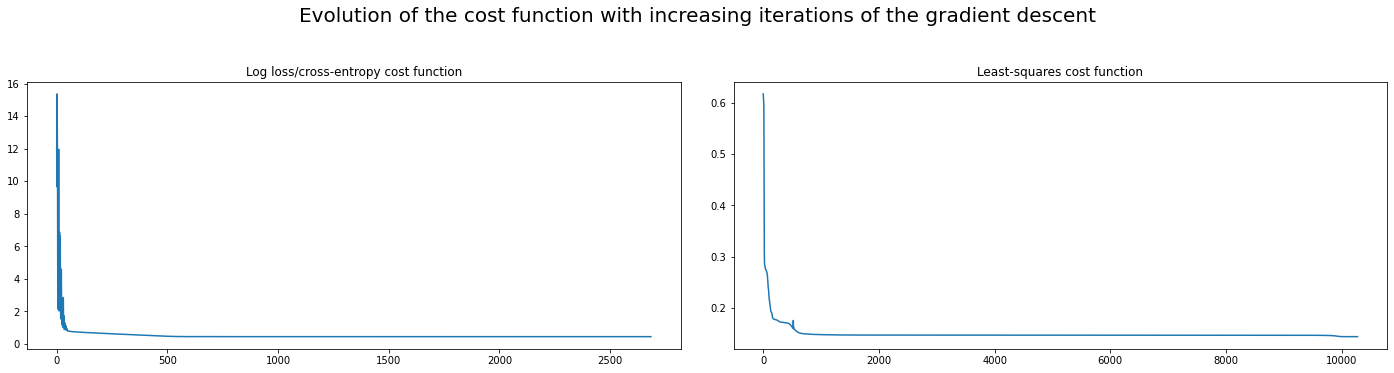

In [35]:
X, w, y, df = logistic_regression_from_scratch("Loan_Status", load_data_wrapper_drop_na)

With our current model & feature engineering, we are able to obtain accuracy scores up to 0.82, which seems to be the maximum score with this model. The spikes in variation in the cost function graphs are due to iterations when the alpha becomes too large for the current position in the function; it is then scaled down, and the gradient descent can continue properly.

## Part II: Logistic Regression using Scikit Learn

To use scikit-learn's logistic regression model, we simply scale our features using the fit_transform method of a MinMaxScaler instance (from the sklearn.preprocessing module) and create an instance of the LogisticRegression/SGDClassifier class from the logistic_model module.

We will divide the dataset into a test and train dataset, using test_train_test.

To retrieve the bias and the weights, we get the intercept_ and coef_ attributes from our LogisticRegression/SGDClassifier instance. We create a function to display the statistics of our linear regression (errors & weights).


In [36]:
def logistic_regression_stats(all_predictions, columns, indicator=accuracy, indicator_name="Accuracy"):
      best = ["", 0]
      for [w, predictions] in all_predictions:
            print("Weights:", len(w), "components")
            print()
            
            dict_w = dict(zip(["Bias"] + list(columns), w))
            print("Coefficients:")
            
            for k, v in dict_w.items():
                  print(f'{k:<30} {v}')
            
            for name, (y, h, score) in predictions.items():
                  ind = indicator(y, h)
                  if (ind > best[1]):
                        best[0] = name
                        best[1] = ind

                  print("\n\n")
                  print(name + " results:")
                  print("**********************************************************************************************\n")
                  print("Model score: %.2f (from scratch), %.2f (sklearn)" % ( accuracy(y,h),
                                                                              score ))

                  print("Mean Absolute Error: %.2f (from scratch), %.2f (sklearn)" % ( meanAbsoluteError(y, h),
                                                                                    mean_absolute_error(y, h) ))
                  print("Root Mean Squared Error: %.2f (from scratch), %.2f (sklearn)" % ( rootMeanSquaredError(y, h),
                                                                                          mean_squared_error(y, h, squared=False) ))
                  print("R2 Score: %.2f (from scratch), %.2f (sklearn)" % ( r2(y, h),
                                                                              r2_score(y, h) ))

                  print("\nConfusion Matrix:\n", confusion_matrix_from_scratch(y, h), "\n(from scratch)\n", confusion_matrix(y, h), "\n(sklearn)\n")
                  print("\nF1 Score: %.2f (from scratch), %.2f (sklearn)" % ( f1(y, h),
                                                                              f1_score(y, h) ))
                  print("Precision: %.2f (from scratch), %.2f (sklearn)" % ( precision(y, h),
                                                                              precision_score(y, h) ))
                  print("Recall: %.2f (from scratch), %.2f (sklearn)" % ( recall(y, h),
                                                                        recall(y, h) ))
                  print("\n**********************************************************************************************")
            
      print("\nBest: [Model Name: %s, %s: %.2f]" % (best[0], indicator_name, best[1]) + "\n\n")

      return best

In [37]:
def merge_dict(dicts):
    super_dict = {}
    for d in dicts:
        for k, v in d.items():
            l=super_dict.setdefault(k,[])
            if v not in l:
                if (hasattr(v, "__iter__")):
                    for sub_v in v:
                        l.append(sub_v)
                else:
                    l.append(v)
    
    return super_dict

def add_prediction(predictions, X, y, model, name):
    predictions[name] = (y, model.predict(X), model.score(X, y))

def logistic_regression_sklearn(predictions, X, y, split_seeds, name="Logistic Regression"):
    for split, seeds in merge_dict(split_seeds).items():
        for seed in seeds:
            model = linear_model.LogisticRegression(random_state = seed, max_iter = 10000)  # Equally, we can use the SGDClassifier (stochastic gradient descent)
                                                                                            # linear model to have a logistic regression model using sklearn
            if split:
                X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = seed, test_size=split)
                model.fit(X_train, y_train)
                weights = list(model.intercept_) + list(model.coef_[0])
                
                preds = {}
                add_prediction(preds, X_train, y_train, model, name + " - Train (Split: " + str(split) + ", Seed: " + str(seed) + ")")
                add_prediction(preds, X_test, y_test, model, name + " - Test (Split: " + str(split) + ", Seed: " + str(seed) + ")")
                predictions.append([weights, preds])

            else:
                model.fit(X, y)
                weights = list(model.intercept_) + list(model.coef_[0])

                preds = {}
                add_prediction(preds, X, y, model, name + " - No split (Seed: " + str(seed) + ")")
                predictions.append([weights, preds])

    return predictions

def logistic_regression_minmax(y_label, loader, split_seeds=[{0.33: 1}]):
    X, y, df = loader(y_label)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    predictions = logistic_regression_sklearn([], X, y, split_seeds)

    logistic_regression_stats(predictions, df.drop(y_label, axis=1).columns)
    
    return X_scaled, w, y, df

In [38]:
X, w, y, df = logistic_regression_minmax("Loan_Status", load_data_wrapper_drop_na, [{False: (1, 2, 3)}, {0.33: (1, 2, 3)}, {0.5: (1, 2, 3)}])

Weights: 27 components

Coefficients:
Bias                           0.17453504897075722
ApplicantIncome                1.3946779952185546e-05
CoapplicantIncome              -5.2910607105136827e-05
LoanAmount                     -0.0015972539775702557
Loan_Amount_Term               -0.0013162440872351
Gender_Female                  0.11401700822484369
Gender_Male                    0.10498584734775546
Gender_Unspecified             -0.05950787199775716
Married_No                     -0.2621797334198826
Married_Unspecified            0.0548289279218779
Married_Yes                    0.3668457890311985
Dependents_0                   0.15669975755644072
Dependents_1                   -0.3494653623601938
Dependents_2                   0.3626510779961612
Dependents_3+                  0.08456139872076487
Dependents_Unspecified         -0.09495188826309597
Education_Graduate             0.1883146095160613
Education_Not Graduate         -0.02881962625622736
Self_Employed_No               0.04

As we can see, the scikit-learn results are very close to that of our logistic regression coded from scratch, with improvement; with our current model, 0.83 is the maximum accuracy we can obtain.

## Part III: Model Testing

We will now experiment with differents strategies for feature engineering in our model. First of all, we will remove the column that have the least correlation with our output column to have a more manageable dataset.

In [39]:
def load_data_wrapper_drop_columns(y, drops):
    df = drop_na_loan_amounts_model()
    for column in drops:
        df = df.drop(column, axis=1)

    X = df.drop(y, axis=1).to_numpy()
    y = df[y].to_numpy()

    return X, y, df

In [40]:
def test_drops(y, drops, indicator=accuracy):
    X, y, df = load_data_wrapper_drop_columns(y, drops)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    predictions = logistic_regression_sklearn([], X_scaled, y, [{False: (2, 3), 0.33: (2, 3)}])

    for [w, preds] in predictions:
        for name, (y, h, score) in preds.items():
            print("%.2f (%s)" % (indicator(y, h), name))

    return df

In [41]:
df = drop_na_loan_amounts_model()
df_corr = df.corr()
print(df_corr["Loan_Status"][df_corr["Loan_Status"] < 0.1][df_corr["Loan_Status"] > -0.1])

ApplicantIncome             -0.005665
CoapplicantIncome           -0.070154
LoanAmount                  -0.041898
Loan_Amount_Term            -0.029979
Gender_Female               -0.028282
Gender_Male                  0.036977
Gender_Unspecified          -0.027021
Married_No                  -0.096014
Married_Unspecified          0.038830
Married_Yes                  0.091018
Dependents_0                 0.006022
Dependents_1                -0.046668
Dependents_2                 0.066947
Dependents_3+               -0.006374
Dependents_Unspecified      -0.062505
Education_Graduate           0.068168
Education_Not Graduate      -0.068168
Self_Employed_No             0.005854
Self_Employed_Unspecified    0.018385
Self_Employed_Yes           -0.018693
Credit_History_2.0           0.038334
Property_Area_Urban         -0.026600
Name: Loan_Status, dtype: float64


In [102]:
print("No drops:")
df = test_drops("Loan_Status", [])

drops = ["ApplicantIncome", "Loan_Amount_Term", "Dependents_0", "Dependents_3+", "Property_Area_Urban", "Self_Employed_Yes", "Self_Employed_No", "Self_Employed_Unspecified"]
print("\nNo employment, gender other than male, property area or applicant income info:")
df = test_drops("Loan_Status", drops)

drops += ["Credit_History_2.0", "Gender_Female", "Gender_Unspecified", "Married_Unspecified"]
print("\nNo employment, gender other than male, property area, applicant income or unspecified credit/married info:")
df = test_drops("Loan_Status", drops)

drops += ["Dependents_1", "Dependents_2", "Dependents_Unspecified", "Gender_Male", "Education_Graduate", "Education_Not Graduate"]
print("\nNo employment, gender, property area, applicant income, number of dependents, education level or unspecified credit/married info:")
df = test_drops("Loan_Status", drops)

drops += ["LoanAmount", "Married_No", "Married_Yes"]
print("\nAll of the above + no loan amount, no marital status info:")
df = test_drops("Loan_Status", drops)

drops += ["CoapplicantIncome", "Property_Area_Rural", "Property_Area_Semiurban"]
print("\nAll of the above + no property area information, no coapplicant income:")
df = test_drops("Loan_Status", drops)

drops_credit_1 = drops + ['Credit_History_1.0']
print("\nAll of the above + no good credit history info:")
df = test_drops("Loan_Status", drops_credit_1)

print(df.columns)

drops_credit_0 = drops + ['Credit_History_0.0']
print("\nAll of the above + no bad credit history info:")
df = test_drops("Loan_Status", drops_credit_0)

print(df.columns)

No drops:
0.81 (Logistic Regression - No split (Seed: 2))
0.81 (Logistic Regression - No split (Seed: 3))
0.80 (Logistic Regression - Train (Split: 0.33, Seed: 2))
0.82 (Logistic Regression - Test (Split: 0.33, Seed: 2))
0.81 (Logistic Regression - Train (Split: 0.33, Seed: 3))
0.82 (Logistic Regression - Test (Split: 0.33, Seed: 3))

No employment, gender other than male, property area or applicant income info:
0.81 (Logistic Regression - No split (Seed: 2))
0.81 (Logistic Regression - No split (Seed: 3))
0.80 (Logistic Regression - Train (Split: 0.33, Seed: 2))
0.82 (Logistic Regression - Test (Split: 0.33, Seed: 2))
0.81 (Logistic Regression - Train (Split: 0.33, Seed: 3))
0.82 (Logistic Regression - Test (Split: 0.33, Seed: 3))

No employment, gender other than male, property area, applicant income or unspecified credit/married info:
0.81 (Logistic Regression - No split (Seed: 2))
0.81 (Logistic Regression - No split (Seed: 3))
0.80 (Logistic Regression - Train (Split: 0.33, Seed: 

Strangely, the accuracy of our logistic regression is the same whether we have only the "Credit_History_0.0" or all collumns. The accuracy of a logistic regression on our dataset only diminishes if the column "Credit_History_0.0" is removed; we can deduce that this column alone contains all the information of the dataset.

Since we removed the "LoanAmount" column from our dataset, we can now retrieve the data rows that we previously removed with the df.dropna() operation, to have a maximum of relevant information.

In [43]:
def load_data_keep_or_remove(y, cols, keep_or_remove="keep"):
    df = one_hot_encoded_filled_dataset()
    if (keep_or_remove == "keep"):
        df = df[cols]
    elif keep_or_remove=="remove":
        df = df[list(set(df.columns) - set(cols))]

    X = df.drop(y, axis=1).to_numpy()
    y = df[y].to_numpy()

    return X, y, df

In [44]:
X, w, y, df = logistic_regression_minmax("Loan_Status", lambda y: load_data_keep_or_remove(y, ["Loan_Status", "Credit_History_1.0"]), [{False: (3), 0.33: (3)}])

X, w, y, df = logistic_regression_minmax("Loan_Status", lambda y: load_data_keep_or_remove(y, ["Loan_Status", "Credit_History_1.0", "Credit_History_2.0"]), [{False: (3), 0.33: (3)}])

X, w, y, df = logistic_regression_minmax("Loan_Status", lambda y: load_data_keep_or_remove(y, ["LoanAmount", "Loan_Amount_Term"], "remove"), [{False: (3), 0.33: (3)}])

Weights: 2 components

Coefficients:
Bias                           -0.702763699723879
Credit_History_1.0             2.0367642029018107



Logistic Regression - No split (Seed: 3) results:
**********************************************************************************************

Model score: 0.77 (from scratch), 0.77 (sklearn)
Mean Absolute Error: 0.23 (from scratch), 0.23 (sklearn)
Root Mean Squared Error: 0.48 (from scratch), 0.48 (sklearn)
R2 Score: -0.07 (from scratch), -0.07 (sklearn)

Confusion Matrix:
 [[ 95.  97.]
 [ 44. 378.]] 
(from scratch)
 [[ 95  97]
 [ 44 378]] 
(sklearn)


F1 Score: 0.84 (from scratch), 0.84 (sklearn)
Precision: 0.80 (from scratch), 0.80 (sklearn)
Recall: 0.90 (from scratch), 0.90 (sklearn)

**********************************************************************************************
Weights: 2 components

Coefficients:
Bias                           -0.8072741009054248
Credit_History_1.0             1.9963358778135523



Logistic Regression - Tra

Though we now have all the rows of our dataset taken into account in the logistic regression, our accuracy score hasn't improved. However, we notice that now if we keep only the Credit_History_1.0, the model isn't as effective as before, and requires to also keep Credit_History_0.0 or Credit_History_2.0 (Unspecified).

Keeping more columns results in a loss on our accuracy score, because the $\Delta$ of sklearn's Logistic Regression is too high to be able to complete the gradient descent to the absolute minimum of the cost function.

We will take a look at the data points are mistaken by our model.

In [104]:
def plot_predictions():
    X, y, df = load_data_keep_or_remove("Loan_Status", ["Loan_Status", "Credit_History_1.0", "Credit_History_2.0"])

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    model = linear_model.LogisticRegression(random_state = 1, max_iter = 10000)
    model.fit(X_scaled, y)

    fig, ((ax1, ax2)) = plt.subplots(2, 1)

    w = list(model.intercept_) + list(model.coef_[0])
    y_pred = hypothesis(np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled], w)

    ax1.scatter(np.linspace(0, len(X_scaled), len(X_scaled)), y_pred, c=y)
    ax1.set_title("For the Credit History only - Accuracy score: %.2f" % accuracy(y, model.predict(X_scaled)), fontsize=20, y=1.05)
    print("Accuracy score: %.2f" % accuracy(y, model.predict(X_scaled)))

    X, y, df = load_data_keep_or_remove("Loan_Status", ["LoanAmount", "Loan_Amount_Term"], "remove")

    X_scaled = scaler.fit_transform(X)
    model.fit(X_scaled, y)

    w = list(model.intercept_) + list(model.coef_[0])
    y_pred = hypothesis(np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled], w)

    ax2.scatter(np.linspace(0, len(X_scaled), len(X_scaled)), y_pred, c=y)
    ax2.set_title("For all columns - Accuracy score: %.2f" % accuracy(y, model.predict(X_scaled)), fontsize=20, y=1.05)

    idxs = np.argwhere(model.predict(X_scaled) != y)
    print("\n\nFalse positives & False negatives :")

    df = load_data_csv("loan_prediction.csv")
    df = df.set_index("Loan_ID")
    df = df.iloc[idxs.flatten(), :]
    df = df.sort_values(["Loan_Status"])
    print(df)

    fig.tight_layout(pad=3.0)
    
    return X, w, y, df

Accuracy score: 0.81


False positives & False negatives :
          Gender Married Dependents     Education Self_Employed  ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History Property_Area Loan_Status
Loan_ID                                                                                                                                                                    
LP001003    Male     Yes          1      Graduate            No             4583             1508.0       128.0             360.0             1.0         Rural           N
LP002341  Female      No          1      Graduate            No             2600                0.0       160.0             360.0             1.0         Urban           N
LP002318  Female      No          1  Not Graduate           Yes             3867                0.0        62.0             360.0             1.0     Semiurban           N
LP002301  Female      No          0      Graduate           Yes             7441 

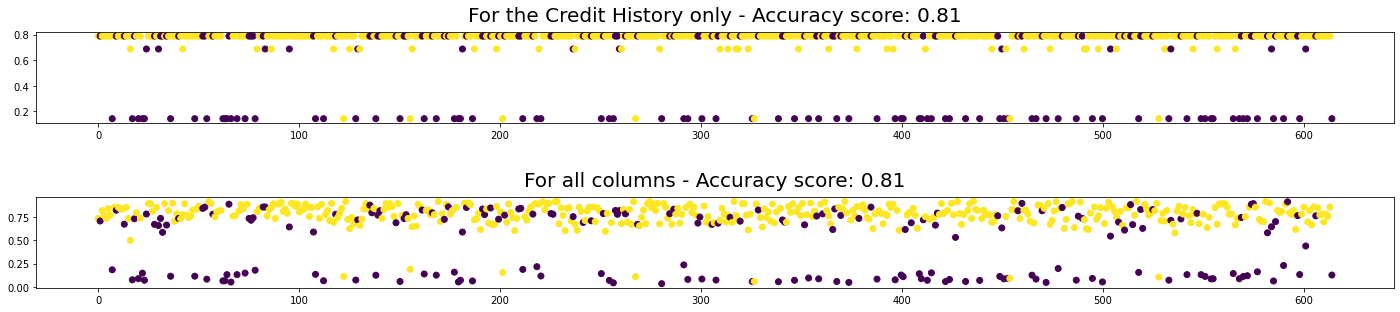

In [105]:
X, w, y, df = plot_predictions()

Using the slope & memory trick, we bump our R2 score to 0.88, which is descent given the fact that we cannot go further than 0.69 with a normal model.

## Part IV: Beyond Logistic Regression

Now we will experiment using other models, such as polynomial regression, GBRs & random forests.


In [106]:
def logistic_polynomial_regression_sklearn(path, y_label, split_seeds=[{0.33: 1}]):
    X, y, df = load_data_keep_or_remove("Loan_Status", ["Loan_Status", "Credit_History_0.0", "Credit_History_1.0", "Credit_History_2.0",
                                                        "Property_Area_Rural", "Property_Area_Semiurban"])

    scaler = MinMaxScaler()
    poly = PolynomialFeatures(2)

    X_scaled = poly.fit_transform(X)
    print(X_scaled.shape)

    X_scaled = scaler.fit_transform(X_scaled)
    print(X_scaled.shape)

    predictions = []
    for split, seeds in merge_dict(split_seeds).items():
        for seed in seeds:
            model = linear_model.LogisticRegression(random_state = seed, max_iter = 10000)
            if split:
                X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = seed, test_size=split)
                model.fit(X_train, y_train)
                weights = list(model.intercept_) + list(model.coef_[0])
                
                preds = {}
                add_prediction(preds, X_train, y_train, model, "Polynomial Logistic Regression - Train (Split: " + str(split) + ", Seed: " + str(seed) + ")")
                add_prediction(preds, X_test, y_test, model, "Polynomial Logistic Regression - Test (Split: " + str(split) + ", Seed: " + str(seed) + ")")
                predictions.append([weights, preds])

            else:
                model.fit(X_scaled, y)
                weights = list(model.intercept_) + list(model.coef_[0])

                preds = {}
                add_prediction(preds, X_scaled, y, model, "Polynomial Logistic Regression - No split (Seed: " + str(seed) + ")")
                predictions.append([weights, preds])

            model = linear_model.LogisticRegression(random_state = seed)

    weights_name = ["Weight" + str(x) for x in range(len(X_scaled[0]))]
    print(weights_name)
    logistic_regression_stats(predictions, weights_name)

    return X_scaled, y, w, df

In [91]:
X, w, y, df = logistic_polynomial_regression_sklearn("loan_prediction.csv", "Loan_Status", [{False: (1, 2, 3)}, {0.33: (1, 2, 3)}])

(614, 21)
(614, 21)
['Weight0', 'Weight1', 'Weight2', 'Weight3', 'Weight4', 'Weight5', 'Weight6', 'Weight7', 'Weight8', 'Weight9', 'Weight10', 'Weight11', 'Weight12', 'Weight13', 'Weight14', 'Weight15', 'Weight16', 'Weight17', 'Weight18', 'Weight19', 'Weight20']
Weights: 22 components

Coefficients:
Bias                           -0.06342137456335636
Weight0                        0.0
Weight1                        -1.198734887327817
Weight2                        0.6252828338956095
Weight3                        0.5734507669619441
Weight4                        -0.07841396024693266
Weight5                        0.1616817396477514
Weight6                        -1.198734887327817
Weight7                        0.0
Weight8                        0.0
Weight9                        0.034349119667849835
Weight10                       0.20509829767258186
Weight11                       0.6252828338956095
Weight12                       0.0
Weight13                       -0.10514949277643601


In [109]:
def polynomial_regression_sklearn(path, y_label, split_seeds=[{0.33: 1}]):
    X, y, df = load_data_keep_or_remove("Loan_Status", ["Loan_Status", "Credit_History_0.0", "Credit_History_1.0", "Credit_History_2.0",
                                                        "Property_Area_Rural", "Property_Area_Semiurban"])

    scaler = MinMaxScaler()
    poly = PolynomialFeatures(2)

    X_scaled = poly.fit_transform(X)
    print(X_scaled.shape)

    X_scaled = scaler.fit_transform(X_scaled)
    print(X_scaled.shape)

    predictions = []
    for split, seeds in merge_dict(split_seeds).items():
        for seed in seeds:
            model = linear_model.LinearRegression(max_iter = 10000)
            if split:
                X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = seed, test_size=split)
                model.fit(X_train, y_train)
                weights = list(model.intercept_) + list(model.coef_[0])
                
                preds = {}
                add_prediction(preds, X_train, y_train, model, "Polynomial Linear Regression - Train (Split: " + str(split) + ", Seed: " + str(seed) + ")")
                add_prediction(preds, X_test, y_test, model, "Polynomial Linear Regression - Test (Split: " + str(split) + ", Seed: " + str(seed) + ")")
                predictions.append([weights, preds])

            else:
                model.fit(X_scaled, y)
                weights = list(model.intercept_) + list(model.coef_[0])

                preds = {}
                add_prediction(preds, X_scaled, y, model, "Polynomial Linear Regression - No split (Seed: " + str(seed) + ")")
                predictions.append([weights, preds])

            model = linear_model.LogisticRegression(random_state = seed)

    weights_name = ["Weight" + str(x) for x in range(len(X_scaled[0]))]
    print(weights_name)
    logistic_regression_stats(predictions, weights_name)

    return X_scaled, y, w, df

In [93]:
X, w, y, df = logistic_polynomial_regression_sklearn("loan_prediction.csv", "Loan_Status", [{False: (1, 2, 3)}, {0.33: (1, 2, 3)}])

(614, 21)
(614, 21)
['Weight0', 'Weight1', 'Weight2', 'Weight3', 'Weight4', 'Weight5', 'Weight6', 'Weight7', 'Weight8', 'Weight9', 'Weight10', 'Weight11', 'Weight12', 'Weight13', 'Weight14', 'Weight15', 'Weight16', 'Weight17', 'Weight18', 'Weight19', 'Weight20']
Weights: 22 components

Coefficients:
Bias                           -0.06342137456335636
Weight0                        0.0
Weight1                        -1.198734887327817
Weight2                        0.6252828338956095
Weight3                        0.5734507669619441
Weight4                        -0.07841396024693266
Weight5                        0.1616817396477514
Weight6                        -1.198734887327817
Weight7                        0.0
Weight8                        0.0
Weight9                        0.034349119667849835
Weight10                       0.20509829767258186
Weight11                       0.6252828338956095
Weight12                       0.0
Weight13                       -0.10514949277643601


Using new features that are polynomial combinations of the ones most correlated with our output variable doesn't increase the model's precision. This is probably due to the fact that since only the Credit_History column is relevant to describe our output variable, only polynomial combinations of this variable will have an impact; and since the variable is binary, all polynomial combinations of the variable are the variable (except for $x^0$, i.e. the bias, where $x$ is the Credit_History feature).

A linear regression would yield the same results as a logistic regression.

In [138]:
def decision_tree_regressor_all_columns():
    X, y, df = load_data_wrapper_drop_columns("Loan_Status", ["LoanAmount", "Loan_Amount_Term"])

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 1, test_size=0.33)
    
    best_test = [0, 0, 0]
    best_train = [0, 0, 0]
    for i in range(1, 20):
        model = DecisionTreeRegressor(max_depth=i)
        model.fit(X_train,y_train)

        y_pred_train = model.predict(X_train)
        best_cut_off_train = generate_cut_off_matrix(y_train, y_pred_train, accuracy, False, "Accuracy score")
        y_pred_train = (y_pred_train > best_cut_off_train).astype(np.int64)
        
        y_pred_test = model.predict(X_test)
        best_cut_off_test = generate_cut_off_matrix(y_test, y_pred_test, accuracy, False, "Accuracy score")
        y_pred_test = (y_pred_test > best_cut_off_train).astype(np.int64)
        
        test_acc = accuracy(y_test, y_pred_test)
        if test_acc > best_test[2]:
            best_test = [i, best_cut_off_test, test_acc]
            
        train_acc = accuracy(y_train, y_pred_train)
        if train_acc > best_train[2]:
            best_train = [i, best_cut_off_train, train_acc]
        
        print("Max_depth %d, Cutoff %.2f (train), %.2f (test): %.2f (train accuracy), %.2f (test accuracy)" 
              % (i, best_cut_off_train, best_cut_off_test, train_acc, test_acc))
        
        if (test_acc > 0.995):
            break

    print('\nBest model accuracy: %.2f (max_depths: %d, cutoff: %.2f)' % (best_test[2], best_test[0],  best_test[1]))
    print('Best model accuracy (overfitted): %.2f (max_depths: %d, cutoff: %.2f)' % (best_train[2], best_train[0],  best_train[1]))

    
    return X, w, y, df

In [139]:
X, w, y, df = decision_tree_regressor_all_columns()

Max_depth 1, Cutoff 0.09 (train), 0.09 (test): 0.82 (train accuracy), 0.80 (test accuracy)
Max_depth 2, Cutoff 0.08 (train), 0.08 (test): 0.82 (train accuracy), 0.79 (test accuracy)
Max_depth 3, Cutoff 0.06 (train), 0.06 (test): 0.82 (train accuracy), 0.80 (test accuracy)
Max_depth 4, Cutoff 0.12 (train), 0.12 (test): 0.84 (train accuracy), 0.80 (test accuracy)
Max_depth 5, Cutoff 0.45 (train), 0.15 (test): 0.86 (train accuracy), 0.76 (test accuracy)
Max_depth 6, Cutoff 0.34 (train), 0.50 (test): 0.88 (train accuracy), 0.78 (test accuracy)
Max_depth 7, Cutoff 0.38 (train), 0.00 (test): 0.90 (train accuracy), 0.76 (test accuracy)
Max_depth 8, Cutoff 0.43 (train), 0.00 (test): 0.93 (train accuracy), 0.75 (test accuracy)
Max_depth 9, Cutoff 0.34 (train), 0.00 (test): 0.95 (train accuracy), 0.74 (test accuracy)
Max_depth 10, Cutoff 0.00 (train), 0.60 (test): 0.96 (train accuracy), 0.75 (test accuracy)
Max_depth 11, Cutoff 0.34 (train), 0.00 (test): 0.97 (train accuracy), 0.72 (test accurac

In [140]:
def decision_tree_classifier_all_columns():
    X, y, df = load_data_wrapper_drop_columns("Loan_Status", ["LoanAmount", "Loan_Amount_Term"])

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 1, test_size=0.33)
    
    best_test = [0, 0]
    best_train = [0, 0]
    for i in range(1, 20):
        model = DecisionTreeClassifier(max_depth=i)
        model.fit(X_train,y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        test_acc = accuracy(y_test, y_pred_test)
        if test_acc > best_test[1]:
            best_test = [i, test_acc]
            
        train_acc = accuracy(y_train, y_pred_train)
        if train_acc > best_train[1]:
            best_train = [i, train_acc]
        
        print("Max_depth %d: %.2f (train accuracy), %.2f (test accuracy)" 
              % (i, train_acc, test_acc))
        
        if (test_acc > 0.995):
            break

    print('\nBest model accuracy: %.2f (max_depths: %d)' % (best_test[1],  best_test[0]))
    print('Best model accuracy (overfitted): %.2f (max_depths: %d)' % (best_train[1],  best_train[0]))

    
    return X, w, y, df

In [141]:
X, w, y, df = decision_tree_classifier_all_columns()

Max_depth 1: 0.82 (train accuracy), 0.80 (test accuracy)
Max_depth 2: 0.82 (train accuracy), 0.79 (test accuracy)
Max_depth 3: 0.82 (train accuracy), 0.80 (test accuracy)
Max_depth 4: 0.84 (train accuracy), 0.80 (test accuracy)
Max_depth 5: 0.86 (train accuracy), 0.76 (test accuracy)
Max_depth 6: 0.88 (train accuracy), 0.79 (test accuracy)
Max_depth 7: 0.90 (train accuracy), 0.75 (test accuracy)
Max_depth 8: 0.93 (train accuracy), 0.74 (test accuracy)
Max_depth 9: 0.95 (train accuracy), 0.75 (test accuracy)
Max_depth 10: 0.96 (train accuracy), 0.74 (test accuracy)
Max_depth 11: 0.97 (train accuracy), 0.73 (test accuracy)
Max_depth 12: 0.98 (train accuracy), 0.70 (test accuracy)
Max_depth 13: 0.99 (train accuracy), 0.73 (test accuracy)
Max_depth 14: 0.99 (train accuracy), 0.73 (test accuracy)
Max_depth 15: 1.00 (train accuracy), 0.71 (test accuracy)
Max_depth 16: 1.00 (train accuracy), 0.72 (test accuracy)
Max_depth 17: 1.00 (train accuracy), 0.70 (test accuracy)
Max_depth 18: 1.00 (tra

In [136]:
def GBR_all_columns():
    X, y, df = load_data_wrapper_drop_columns("Loan_Status", ["LoanAmount", "Loan_Amount_Term"])

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 1, test_size=0.33)
    
    best_test = [0, 0, 0]
    best_train = [0, 0, 0]
    for i in range(1, 20):
        model = GradientBoostingRegressor(max_depth=i)
        model.fit(X_train,y_train)

        y_pred_train = model.predict(X_train)
        best_cut_off_train = generate_cut_off_matrix(y_train, y_pred_train, accuracy, False, "Accuracy score")
        y_pred_train = (y_pred_train > best_cut_off_train).astype(np.int64)
        
        y_pred_test = model.predict(X_test)
        best_cut_off_test = generate_cut_off_matrix(y_test, y_pred_test, accuracy, False, "Accuracy score")
        y_pred_test = (y_pred_test > best_cut_off_train).astype(np.int64)
        
        test_acc = accuracy(y_test, y_pred_test)
        if test_acc > best_test[2]:
            best_test = [i, best_cut_off_test, test_acc]
            
        train_acc = accuracy(y_train, y_pred_train)
        if train_acc > best_train[2]:
            best_train = [i, best_cut_off_train, train_acc]
        
        print("Max_depth %d, Cutoff %.2f (train), %.2f (test): %.2f (train accuracy), %.2f (test accuracy)" 
              % (i, best_cut_off_train, best_cut_off_test, train_acc, test_acc))
        
        if (test_acc > 0.995):
            break

    print('\nBest model accuracy: %.2f (max_depths: %d, cutoff: %.2f)' % (best_test[2], best_test[0],  best_test[1]))
    print('Best model accuracy (overfitted): %.2f (max_depths: %d, cutoff: %.2f)' % (best_train[2], best_train[0],  best_train[1]))

    
    return X, w, y, df

In [137]:
X, w, y, df = GBR_all_columns()

Max_depth 1, Cutoff 0.65 (train), 0.28 (test): 0.83 (train accuracy), 0.80 (test accuracy)
Max_depth 2, Cutoff 0.68 (train), 0.56 (test): 0.89 (train accuracy), 0.73 (test accuracy)
Max_depth 3, Cutoff 0.68 (train), 0.39 (test): 0.97 (train accuracy), 0.71 (test accuracy)
Max_depth 4, Cutoff 0.68 (train), 0.21 (test): 0.99 (train accuracy), 0.74 (test accuracy)
Max_depth 5, Cutoff 0.46 (train), 0.23 (test): 1.00 (train accuracy), 0.75 (test accuracy)
Max_depth 6, Cutoff 0.36 (train), 0.28 (test): 1.00 (train accuracy), 0.76 (test accuracy)
Max_depth 7, Cutoff 0.20 (train), 0.17 (test): 1.00 (train accuracy), 0.79 (test accuracy)
Max_depth 8, Cutoff 0.12 (train), 0.04 (test): 1.00 (train accuracy), 0.77 (test accuracy)
Max_depth 9, Cutoff 0.06 (train), 0.01 (test): 1.00 (train accuracy), 0.77 (test accuracy)
Max_depth 10, Cutoff 0.02 (train), 0.01 (test): 1.00 (train accuracy), 0.79 (test accuracy)
Max_depth 11, Cutoff 0.01 (train), 0.01 (test): 1.00 (train accuracy), 0.78 (test accurac

In [134]:
def GBC_all_columns():
    X, y, df = load_data_wrapper_drop_columns("Loan_Status", ["LoanAmount", "Loan_Amount_Term"])

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 1, test_size=0.33)
    
    best_test = [0, 0]
    best_train = [0, 0]
    for i in range(1, 20):
        model = GradientBoostingClassifier(max_depth=i)
        model.fit(X_train,y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        test_acc = accuracy(y_test, y_pred_test)
        if test_acc > best_test[1]:
            best_test = [i, test_acc]
            
        train_acc = accuracy(y_train, y_pred_train)
        if train_acc > best_train[1]:
            best_train = [i, train_acc]
        
        print("Max_depth %d: %.2f (train accuracy), %.2f (test accuracy)" 
              % (i, train_acc, test_acc))
        
        if (test_acc > 0.995):
            break

    print('\nBest model accuracy: %.2f (max_depths: %d)' % (best_test[1],  best_test[0]))
    print('Best model accuracy (overfitted): %.2f (max_depths: %d)' % (best_train[1],  best_train[0]))

    
    return X, w, y, df

In [135]:
X, w, y, df = GBC_all_columns()

Max_depth 1: 0.82 (train accuracy), 0.80 (test accuracy)
Max_depth 2: 0.85 (train accuracy), 0.80 (test accuracy)
Max_depth 3: 0.93 (train accuracy), 0.80 (test accuracy)
Max_depth 4: 0.98 (train accuracy), 0.79 (test accuracy)
Max_depth 5: 0.99 (train accuracy), 0.75 (test accuracy)
Max_depth 6: 1.00 (train accuracy), 0.77 (test accuracy)
Max_depth 7: 1.00 (train accuracy), 0.75 (test accuracy)
Max_depth 8: 1.00 (train accuracy), 0.76 (test accuracy)
Max_depth 9: 1.00 (train accuracy), 0.75 (test accuracy)
Max_depth 10: 1.00 (train accuracy), 0.77 (test accuracy)
Max_depth 11: 1.00 (train accuracy), 0.75 (test accuracy)
Max_depth 12: 1.00 (train accuracy), 0.77 (test accuracy)
Max_depth 13: 1.00 (train accuracy), 0.73 (test accuracy)
Max_depth 14: 1.00 (train accuracy), 0.73 (test accuracy)
Max_depth 15: 1.00 (train accuracy), 0.73 (test accuracy)
Max_depth 16: 1.00 (train accuracy), 0.73 (test accuracy)
Max_depth 17: 1.00 (train accuracy), 0.74 (test accuracy)
Max_depth 18: 1.00 (tra

In [130]:
def random_forest_regressor_all_columns():
    X, y, df = load_data_wrapper_drop_columns("Loan_Status", ["LoanAmount", "Loan_Amount_Term"])

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 1, test_size=0.33)
    
    best_test = [0, 0, 0]
    best_train = [0, 0, 0]
    for i in range(1, 20):
        model = RandomForestRegressor(max_depth=i)
        model.fit(X_train,y_train)

        y_pred_train = model.predict(X_train)
        best_cut_off_train = generate_cut_off_matrix(y_train, y_pred_train, accuracy, False, "Accuracy score")
        y_pred_train = (y_pred_train > best_cut_off_train).astype(np.int64)
        
        y_pred_test = model.predict(X_test)
        best_cut_off_test = generate_cut_off_matrix(y_test, y_pred_test, accuracy, False, "Accuracy score")
        y_pred_test = (y_pred_test > best_cut_off_train).astype(np.int64)
        
        test_acc = accuracy(y_test, y_pred_test)
        if test_acc > best_test[2]:
            best_test = [i, best_cut_off_test, test_acc]
            
        train_acc = accuracy(y_train, y_pred_train)
        if train_acc > best_train[2]:
            best_train = [i, best_cut_off_train, train_acc]
        
        print("Max_depth %d, Cutoff %.2f (train), %.2f (test): %.2f (train accuracy), %.2f (test accuracy)" 
              % (i, best_cut_off_train, best_cut_off_test, train_acc, test_acc))
        
        if (test_acc > 0.995):
            break

    print('\nBest model accuracy: %.2f (max_depths: %d, cutoff: %.2f)' % (best_test[2], best_test[0],  best_test[1]))
    print('Best model accuracy (overfitted): %.2f (max_depths: %d, cutoff: %.2f)' % (best_train[2], best_train[0],  best_train[1]))

    
    return X, w, y, df

In [131]:
X, w, y, df = random_forest_regressor_all_columns()

Max_depth 1, Cutoff 0.09 (train), 0.09 (test): 0.82 (train accuracy), 0.80 (test accuracy)
Max_depth 2, Cutoff 0.70 (train), 0.67 (test): 0.82 (train accuracy), 0.80 (test accuracy)
Max_depth 3, Cutoff 0.69 (train), 0.67 (test): 0.84 (train accuracy), 0.80 (test accuracy)
Max_depth 4, Cutoff 0.65 (train), 0.56 (test): 0.86 (train accuracy), 0.77 (test accuracy)
Max_depth 5, Cutoff 0.67 (train), 0.55 (test): 0.90 (train accuracy), 0.76 (test accuracy)
Max_depth 6, Cutoff 0.71 (train), 0.52 (test): 0.94 (train accuracy), 0.76 (test accuracy)
Max_depth 7, Cutoff 0.64 (train), 0.46 (test): 0.96 (train accuracy), 0.77 (test accuracy)
Max_depth 8, Cutoff 0.62 (train), 0.34 (test): 0.98 (train accuracy), 0.77 (test accuracy)
Max_depth 9, Cutoff 0.52 (train), 0.40 (test): 0.98 (train accuracy), 0.78 (test accuracy)
Max_depth 10, Cutoff 0.60 (train), 0.19 (test): 0.99 (train accuracy), 0.77 (test accuracy)
Max_depth 11, Cutoff 0.54 (train), 0.16 (test): 0.99 (train accuracy), 0.79 (test accurac

In [132]:
def random_forest_classifier_all_columns():
    X, y, df = load_data_wrapper_drop_columns("Loan_Status", ["LoanAmount", "Loan_Amount_Term"])

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 1, test_size=0.33)
    
    best_test = [0, 0]
    best_train = [0, 0]
    for i in range(1, 20):
        model = RandomForestClassifier(max_depth=i)
        model.fit(X_train,y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        test_acc = accuracy(y_test, y_pred_test)
        if test_acc > best_test[1]:
            best_test = [i, test_acc]
            
        train_acc = accuracy(y_train, y_pred_train)
        if train_acc > best_train[1]:
            best_train = [i, train_acc]
        
        print("Max_depth %d: %.2f (train accuracy), %.2f (test accuracy)" 
              % (i, train_acc, test_acc))
        
        if (test_acc > 0.995):
            break

    print('\nBest model accuracy: %.2f (max_depths: %d)' % (best_test[1],  best_test[0]))
    print('Best model accuracy (overfitted): %.2f (max_depths: %d)' % (best_train[1],  best_train[0]))

    
    return X, w, y, df

In [133]:
X, w, y, df = random_forest_classifier_all_columns()

Max_depth 1: 0.70 (train accuracy), 0.70 (test accuracy)
Max_depth 2: 0.82 (train accuracy), 0.80 (test accuracy)
Max_depth 3: 0.82 (train accuracy), 0.80 (test accuracy)
Max_depth 4: 0.82 (train accuracy), 0.80 (test accuracy)
Max_depth 5: 0.82 (train accuracy), 0.80 (test accuracy)
Max_depth 6: 0.83 (train accuracy), 0.80 (test accuracy)
Max_depth 7: 0.85 (train accuracy), 0.80 (test accuracy)
Max_depth 8: 0.90 (train accuracy), 0.80 (test accuracy)
Max_depth 9: 0.93 (train accuracy), 0.79 (test accuracy)
Max_depth 10: 0.94 (train accuracy), 0.79 (test accuracy)
Max_depth 11: 0.96 (train accuracy), 0.79 (test accuracy)
Max_depth 12: 0.98 (train accuracy), 0.76 (test accuracy)
Max_depth 13: 0.99 (train accuracy), 0.76 (test accuracy)
Max_depth 14: 0.99 (train accuracy), 0.77 (test accuracy)
Max_depth 15: 0.99 (train accuracy), 0.75 (test accuracy)
Max_depth 16: 1.00 (train accuracy), 0.76 (test accuracy)
Max_depth 17: 1.00 (train accuracy), 0.74 (test accuracy)
Max_depth 18: 1.00 (tra

With models derived from decision trees, we can easily obtain an accuracy score nearing 1 with max_detphs superior to 5. However, those models are extremely overfitted, and they cannot apply to a dataset divided between a train and test set. From this fact, we can deduce that there are no common machine learning models that can 

## Second Dataset: Experimentation on the MNIST Dataset

Just for fun, we will try out a Logistic Regression model on the MNIST dataset, on which most Machine Learning models will work even though the process of digit recognition is not trivial.

The dataset is a vector of 2D greyscale images, with an output variable indicating which digit is displayed on the picture. To make the images usable for a logistic regression, we will combine all the lines of pixels in the image into one line; each pixel of this new line will correspond to a weight of our logistic regression.

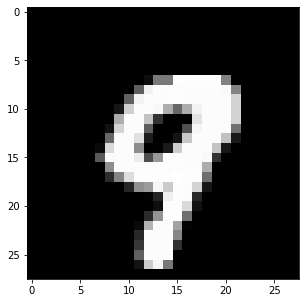

Example Digit:  9
Dataset Dimensions:  (60000, 28, 28)
0.92345
0.9182

Predictions

    y_true     y_pred
         7          7
         2          2
         1          1
         0          0
         4          4
         1          1
         4          4
         9          9
         5          6
         9          9
         0          0
         6          6
         9          9
         0          0
         1          1
         5          5
         9          9
         7          7
         3          6
         4          4
         9          9
         6          6
         6          6
         5          5
         4          4
         0          0
         7          7
         4          4
         0          0
         1          1


In [144]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

i  = np.random.randint(0, len(x_train), 1)[0]

plt.imshow(x_train[i], cmap="gray")
plt.show()
print("Example Digit: ", y_train[i])

print("Dataset Dimensions: ", x_train.shape)

MAX_VALUE = 255
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]) / MAX_VALUE  #  Scaling our features by dividing them by the theoritical 
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2]) / MAX_VALUE       #  maximum value of each pixel (255 in greyscale)


model = linear_model.SGDClassifier(tol=0.000001)  # We lower the tolerance (delta) of our model to obtain the best results
model.fit(x_train, y_train)

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

y_pred = model.predict(x_test)

print("\nPredictions\n")
print("{: >10} {: >10}".format("y_true", "y_pred"))
for y, y_p in zip(y_test[:30], y_pred[:30]):
    print("{: >10} {: >10}".format(y, y_p))

Using logistic regression, we can get an accuracy of prediction of ~0.92 on the MNIST Dataset, which is a more-than-decent fit considering there are 9 possible classes. However, it makes sense that such a good fit would be possible as some pixel groups are determinant in categorising digits (like in a 8-segment display, a specific combination of "lit" pixels can only be for some specific numbers, and a very simple logical system can modelize the relationship between those "lit" shapes and which number is displayed).